In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

plt.rcParams['figure.figsize'] = [20, 4]

# Set the device      
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


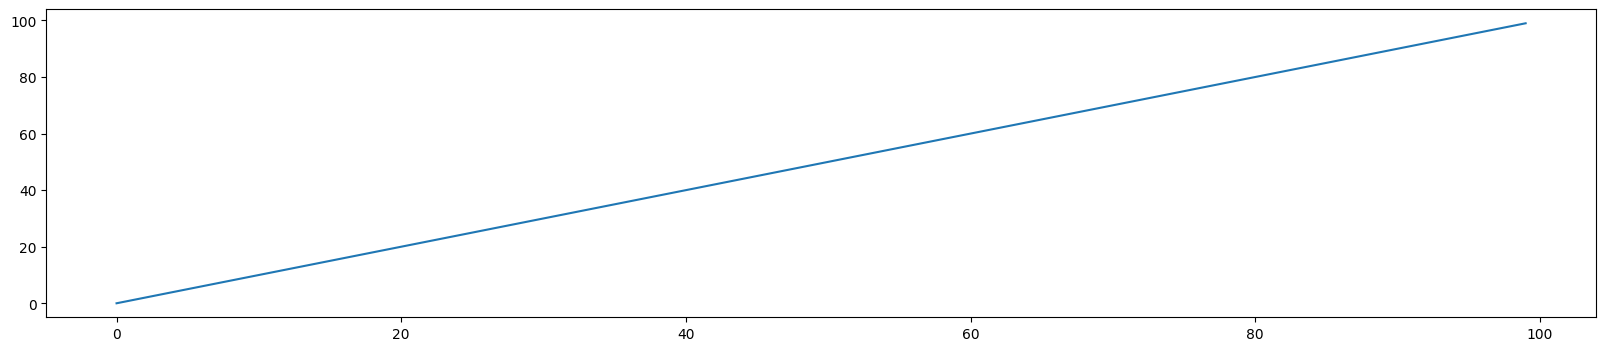

In [81]:
class DataGenerator:
    def __init__(self, f):
        self.f = f

    def __call__(self, n):
        y = np.array(self.f(np.arange(n)), dtype=np.float32)
        return y

f1 = lambda x: 0.1*x+x*0.01*np.sin(x/16*2*np.pi)
f2 = lambda x: x
dgen = DataGenerator(f2)
timeseries = dgen(100).reshape(-1, 1)
plt.plot(timeseries)

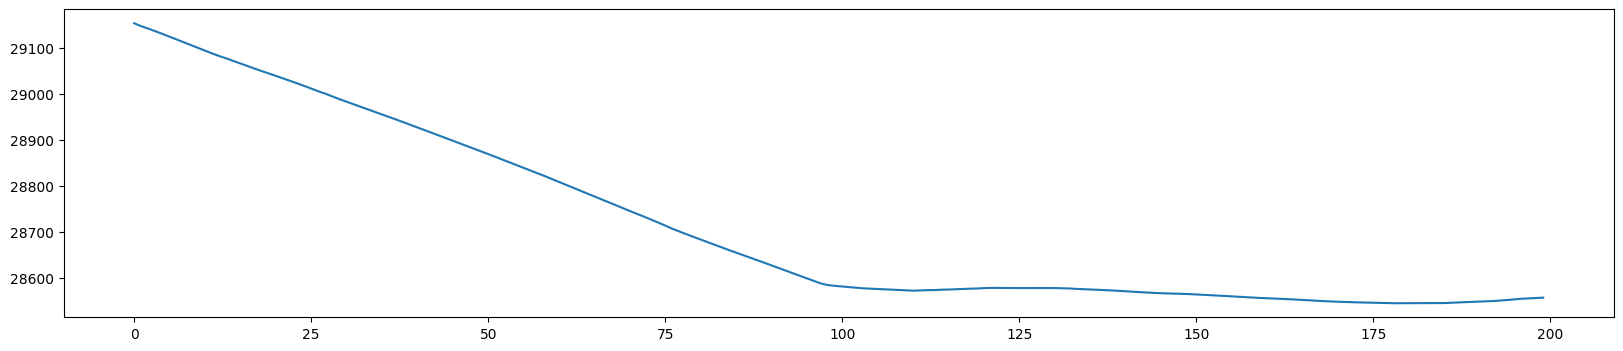

In [39]:
df = pd.read_csv("./data/BTCUSD_PERP-1m-2023-05.csv")
timeseries = df[["close"]].rolling(120).mean().values.astype('float32')[120:320]

plt.plot(timeseries);

In [66]:
def filter_dset(dset, dt, dp):
    ids = []    
    for i in range(dt, len(dset)):
        if (dset[i] - dset[i-dt])/dset[i-dt] > dp:
            ids.append(i)
    return ids

def create_dset(dset, lookback, ids=None):
    """Transform a time series into a prediction dset
    
    Args:
        dset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    if ids is None:
        ids = list(range(lookback-1, len(dset)-lookback))
    else:
        ids = [i for i in ids if i < len(dset)-lookback]

    for i in ids:
        i -= lookback-1
        feature = dset[i:i+lookback]
        target = dset[i+1:i+lookback+1].copy()
        # target[-1] = dset[i+2*lookback-1] #(dset[i+1:i+lookback+1] - dset[i:i+lookback])/dset[i:i+lookback]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)


# train-test split for time series
train_size = int(len(timeseries) * 0.8)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

lookback = 8
dp = 0.006
X_train, y_train = create_dset(train, lookback=lookback, ids=None)#filter_dset(train, lookback, dp))
X_test, y_test = create_dset(test, lookback=lookback, ids=None)#ffilter_dset(test, lookback, dp))
train_size, test_size = y_train.shape[0], y_test.shape[0]
print(f"Train {y_train.shape} on {y_train.device}")
print(f"Test {y_test.shape} on {y_test.device}")

Train torch.Size([785, 8, 1]) on cpu
Test torch.Size([185, 8, 1]) on cpu


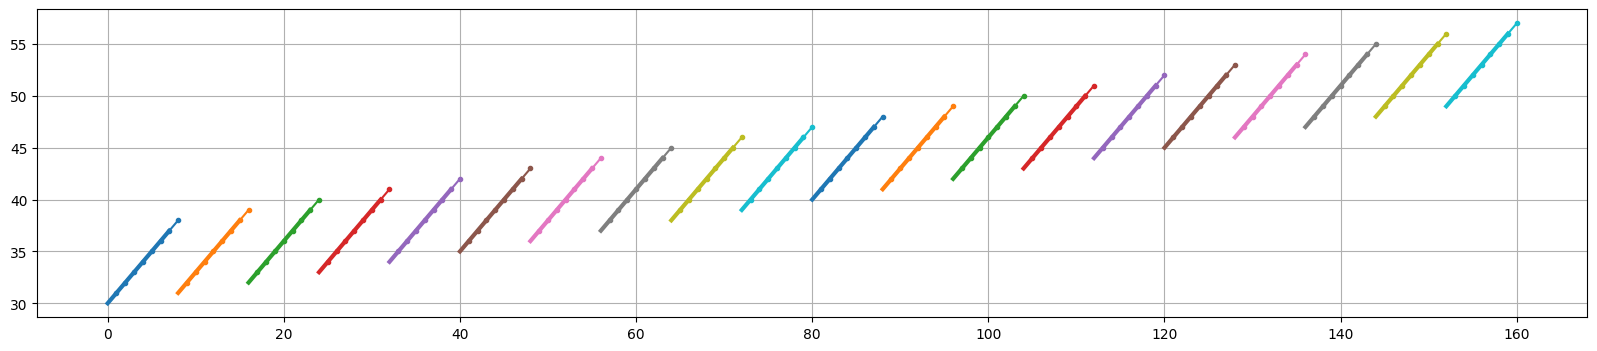

In [67]:
n1, n2 = 30, 50
for i, x in enumerate(X_train[n1:n2]):
    plt.plot(list(range(i*lookback, lookback+i*lookback)), x, "-", linewidth=3)
for i, x in enumerate(y_train[n1:n2]):
    plt.plot(list(range(i*lookback+1, lookback+i*lookback+1)), x, ".-")
plt.grid("on")

In [77]:
class AirModel(nn.Module):
    def __init__(self, n_lstm=8, n_linear=8):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=n_lstm, num_layers=1, batch_first=True)
        self.linear_trans = nn.Linear(n_lstm, n_linear)
        self.linear_inner = nn.Linear(n_linear, n_linear)
        self.linear_out = nn.Linear(n_linear, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        # x = self.linear_trans(x)
        # x = nn.ReLU()(x)
        # x = self.linear_inner(x)
        # x = nn.ReLU()(x)
        x = self.linear_out(x)
        return x
    
    def predict(self, x):
        dx = self.forward(x)[:, -1, :]
        return x[:, -1]#*(dx + 1)
model = AirModel(32, 32).to("mps")

In [78]:
optimizer = optim.Adam(model.parameters(), 0.01)
loss_fn = nn.MSELoss()

X_train, y_train, X_test, y_test = X_train.to("mps"), y_train.to("mps"), X_test.to("mps"), y_test.to("mps")
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 10 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = torch.pow(loss_fn(y_pred[:, -1], y_train[:, -1]), 0.5)
        y_pred = model(X_test)
        test_rmse = torch.pow(loss_fn(y_pred[:, -1], y_test[:, -1]), 0.5)
    print("Epoch %d: train RMSE %08.2f, test RMSE %08.2f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 00438.23, test RMSE 00876.73
Epoch 10: train RMSE 00255.45, test RMSE 00645.22
Epoch 20: train RMSE 00153.15, test RMSE 00490.96
Epoch 30: train RMSE 00084.18, test RMSE 00366.19
Epoch 40: train RMSE 00043.41, test RMSE 00274.42
Epoch 50: train RMSE 00058.22, test RMSE 00277.32
Epoch 60: train RMSE 00038.04, test RMSE 00252.70
Epoch 70: train RMSE 00032.59, test RMSE 00206.63
Epoch 80: train RMSE 00025.40, test RMSE 00224.17
Epoch 90: train RMSE 00036.36, test RMSE 00257.18


/var/folders/kw/hd5pllps0vs0ln9s5xlr768w0000gn/T/ipykernel_90482/2956876258.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)


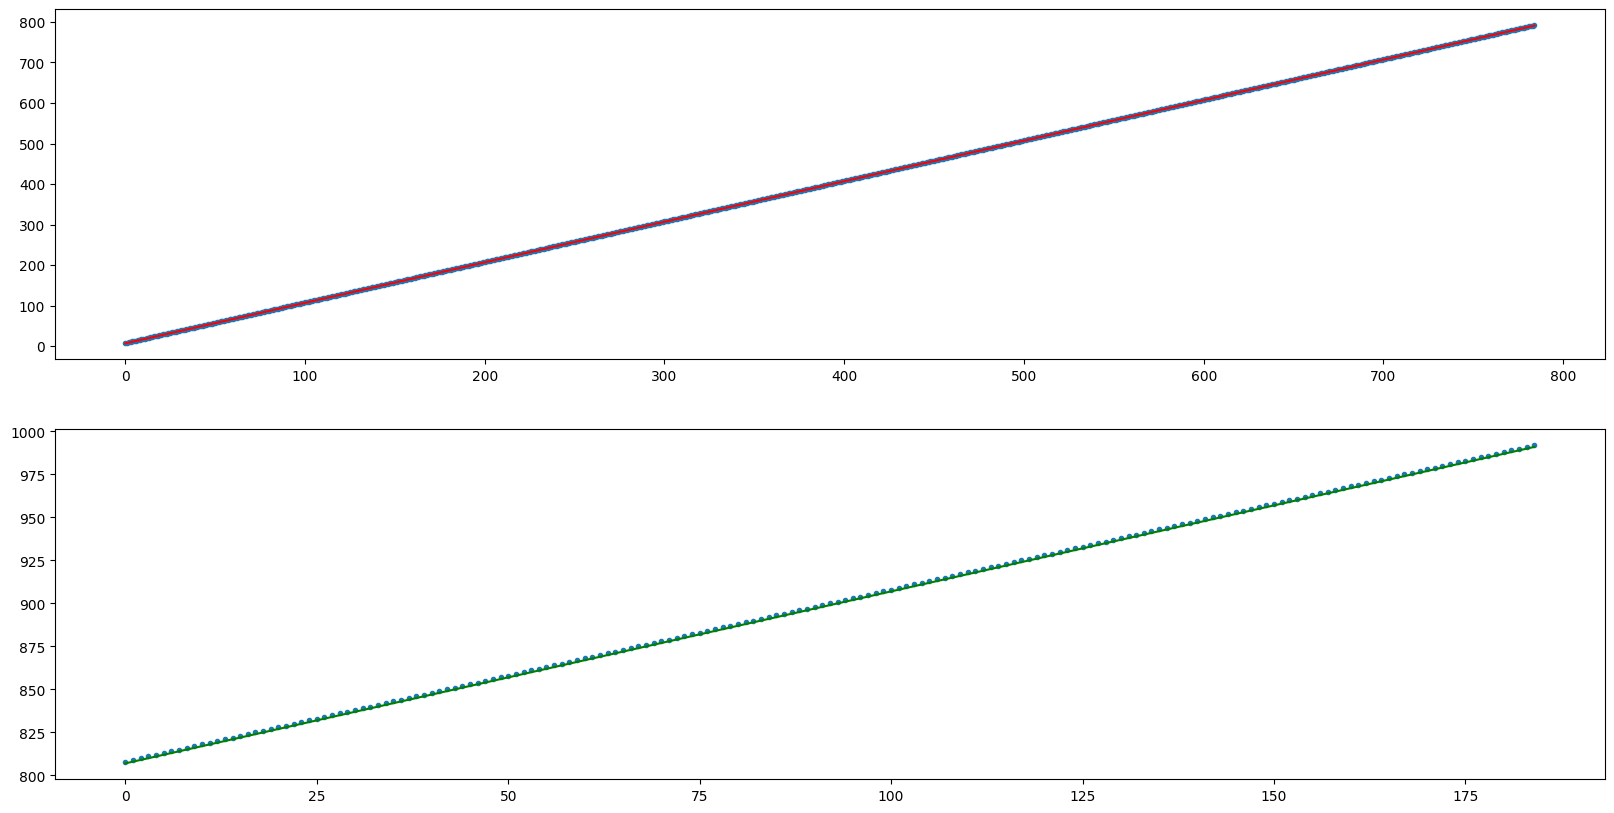

In [79]:
with torch.no_grad():
    y_pred4train = model.predict(X_train.to("mps")).cpu()
    y_pred4test = model.predict(X_test.to("mps")).cpu()
# plot
plt.subplots(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.plot(y_train[:, -1].cpu(), ".")
plt.plot(y_pred4train.cpu(), c='r')
plt.subplot(2, 1, 2)
plt.plot(y_test[:, -1].cpu(), ".")
plt.plot(y_pred4test.cpu(), c='g')
# plt.xlim([0, 1000])

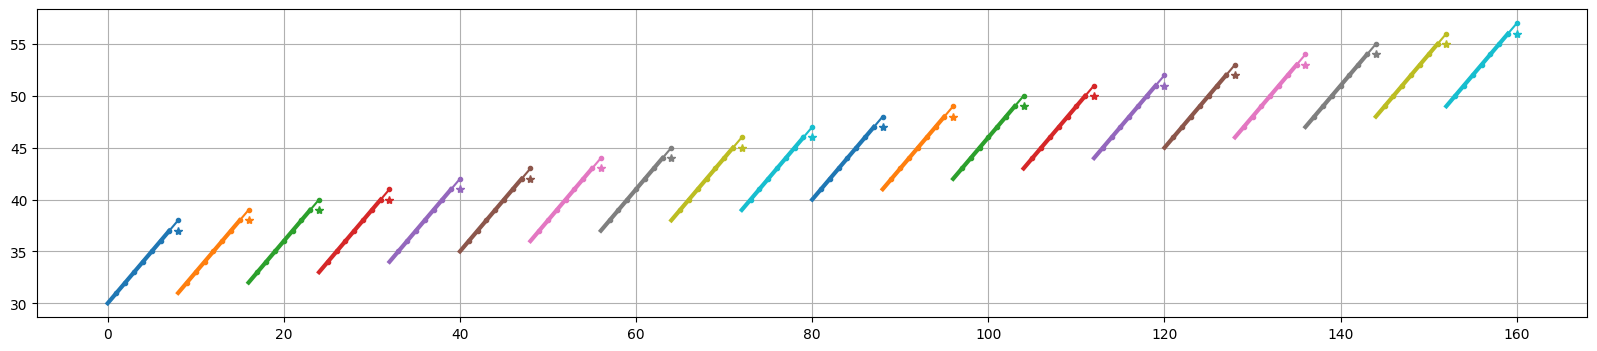

In [80]:
n1, n2 = 30, 50
for i, x in enumerate(X_train[n1:n2].cpu()):
    plt.plot(list(range(i*lookback, lookback+i*lookback)), x, "-", linewidth=3)
for i, x in enumerate(y_train[n1:n2].cpu()):
    plt.plot(list(range(i*lookback+1, lookback+i*lookback+1)), x, ".-")
for i, x in enumerate(y_pred4train[n1:n2]):
    plt.plot([lookback+i*lookback], x, "*")
plt.grid("on")

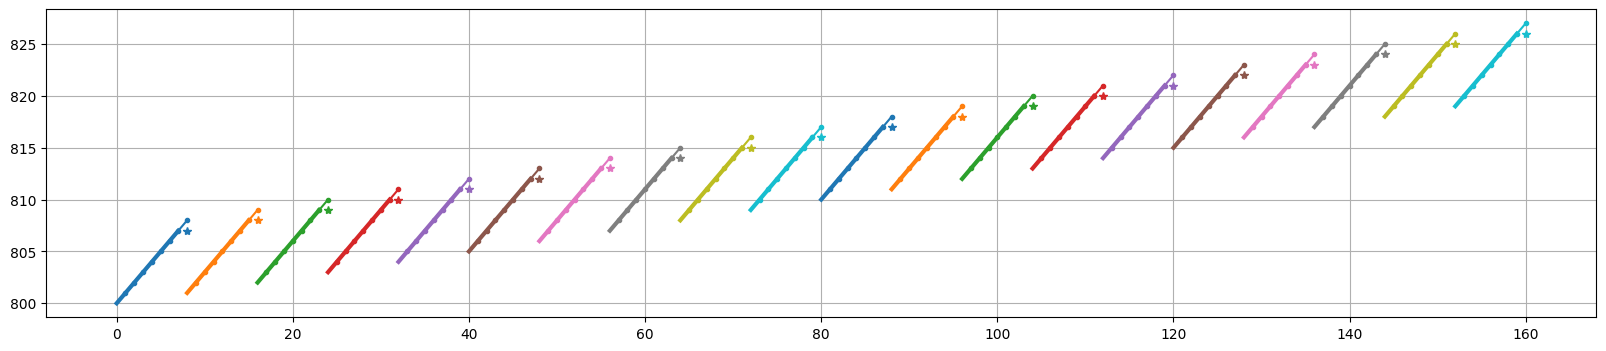

In [72]:
n1, n2 = 0, 20
for i, x in enumerate(X_test[n1:n2].cpu()):
    plt.plot(list(range(i*lookback, lookback+i*lookback)), x, "-", linewidth=3)
for i, x in enumerate(y_test[n1:n2].cpu()):
    plt.plot(list(range(i*lookback+1, lookback+i*lookback+1)), x, ".-")
for i, x in enumerate(y_pred4test[n1:n2]):
    plt.plot([lookback+i*lookback], x, "*")
plt.grid("on")

In [74]:
loss_fn(model(X_train[:3]), X_train[:3])

tensor(43.2763, device='mps:0', grad_fn=<MseLossBackward0>)

In [55]:
y_train[:3]

tensor([[[0.9802],
         [1.9509],
         [2.9028],
         [3.8268],
         [4.7140],
         [5.5557],
         [6.3439],
         [7.0711]],

        [[1.9509],
         [2.9028],
         [3.8268],
         [4.7140],
         [5.5557],
         [6.3439],
         [7.0711],
         [7.7301]],

        [[2.9028],
         [3.8268],
         [4.7140],
         [5.5557],
         [6.3439],
         [7.0711],
         [7.7301],
         [8.3147]]], device='mps:0')